In [11]:
from presidio_analyzer import AnalyzerEngine, PatternRecognizer
import numpy as np
import pandas as pd
import json
from tqdm import tqdm

In [12]:
class UIIAnalyzer:
    def __init__(self, df):
        self.analyzer = AnalyzerEngine()
        self.entities = None
        self.df = df
        self.lang = 'en'
        self.results = {}
        self.formattedResults = {}
    
    def analyzeAll(self):
        self.results.clear()
        totcount = df.shape[0]
        for row in tqdm(self.df.itertuples(), total=totcount):
            analyzer_results = self.analyzer.analyze(text=row.sentence, entities=self.entities, language=self.lang)
            self.results[str(row.id)] = {'text': row.sentence, 'results': analyzer_results}
    
    def getPlainResults(self):
        if not self.results:
            print("ERR! - First analyze your dataset!")
            return {}
        return self.results
            
#     def getFormattedResults(self):
#         if self.formattedResults:
#             return self.formattedResults
        
#         for form_id, result in self.results.items():
#             entities = []
#             for entity in result['results']:
#                 entity_dict = {}
#                 entity_dict['type'] = entity.entity_type
#                 entity_dict['start'] = entity.start
#                 entity_dict['end'] = entity.end
#                 entity_dict['score'] = entity.score
#                 entities.append(entity_dict)
#             self.formattedResults[form_id] = {'text': result['text'], 'entities': entities}
            
#         return self.formattedResults
    
    def getFormattedResults(self):
        if self.formattedResults:
            return self.formattedResults
        
        for form_id, result in self.results.items():
            entities = []
            for entity in result['results']:
                entity_dict = {}
                entity_dict['type'] = entity.entity_type
                entity_dict['substr'] = result['text'][entity.start:entity.end]
                entity_dict['score'] = entity.score
                entities.append(entity_dict)
            self.formattedResults[form_id] = entities
            
        return self.formattedResults
    
    
    def readFormattedResults(self, path):
        with open(path) as f:
            self.formattedResults = json.load(f)
            
    def writeFormattedResults(self, path):
        with open(path, "w") as f:
            json.dump(analyzer.getFormattedResults(), f)
            
    def basicStats(self):
        pass
        # first learn how many read forms might have PII
        # then, learn how many read forms have specific PII
        # then, learn how many PII are there for each group

In [13]:
class UIIStatistics:
    def __init__(self, path):
        self.path = path
        with open(path) as f:
            self.results = json.load(f)
    
    def formIncludesPII(self):
        include, not_include = 0, 0
        for form_id, result in self.results.items():
            if not result:
                not_include += 1
            else:
                include += 1
        return {'Forms containing PII': include, 'Forms not containing PII': not_include}
    
    def hasSpecificPII(self):
        include, not_include = 0, 0
        for form_id, result in self.results.items():
            if not result:
                not_include += 1
            else:
                include += 1
        return {'Forms containing PII': include, 'Forms not containing PII': not_include}
    
    def countPIIs(self):
        pii_count = {}
        for form_id, result in self.results.items():
            result = result['entities']
            id_pii_count = {}
            for entity in result:
                if entity['type'] in id_pii_count:
                    id_pii_count[entity['type']] = id_pii_count[entity['type']] + 1
                else:
                    id_pii_count[entity['type']] = 1
            pii_count[form_id] = id_pii_count
        return pii_count
    
    def PIIScores(self):
        pii_count = {}
        for form_id, result in self.results.items():
            result = result['entities']
            for entity in result:
                score_str = str(round(entity['score'], 2)) 
                if entity['type'] in pii_count:
                    if score_str in pii_count[entity['type']]:
                        pii_count[entity['type']][score_str] = pii_count[entity['type']][score_str] + 1
                    else:
                        pii_count[entity['type']][score_str] = 1
                else:
                    pii_count[entity['type']] = {score_str: 1}
        return pii_count
    
    def allPIICounts(self):
        pii_count = self.countPIIs()
        all_count = {}
        for form_id, type_counts in pii_count.items():
            for entity_type, count in type_counts.items():
                if entity_type not in all_count:
                    all_count[entity_type] = 1
                else:
                    all_count[entity_type] = all_count[entity_type] + 1
        return all_count
                    
                

In [14]:
df = pd.read_csv('clean_text.csv')
df.describe()

,id,eng_score
count,6.191100e+04,61911.000000
mean,1.620374e+14,0.937140
std,6.322364e+13,0.021926
min,2.000000e+00,0.900001
25%,9.101660e+13,0.919101
50%,2.018945e+14,0.936288
75%,2.106085e+14,0.953522
max,2.115931e+14,0.999874


In [15]:
analyzer = UIIAnalyzer(df)

In [16]:
analyzer.analyzeAll()

100%|██████████| 61911/61911 [31:58<00:00, 32.26it/s]  


In [17]:
analyzer.getFormattedResults()

{'60405483339961': [{'type': 'DATE_TIME', 'substr': 'Today', 'score': 0.85}],
 '73095534284158': [{'type': 'PERSON', 'substr': 'Edison', 'score': 0.85},
  {'type': 'PERSON', 'substr': 'Mattie Nottage', 'score': 0.85}],
 '81541209182856': [{'type': 'DATE_TIME',
   'substr': 'Number of years',
   'score': 0.85},
  {'type': 'DATE_TIME', 'substr': 'the first year', 'score': 0.85},
  {'type': 'DATE_TIME', 'substr': 'the third year', 'score': 0.85},
  {'type': 'DATE_TIME', 'substr': 'less than 10 years old', 'score': 0.85},
  {'type': 'DATE_TIME', 'substr': 'day 1', 'score': 0.85},
  {'type': 'DATE_TIME', 'substr': 'the last 5 years', 'score': 0.85},
  {'type': 'DATE_TIME', 'substr': 'five years', 'score': 0.85}],
 '201187727633054': [{'type': 'DATE_TIME',
   'substr': 'this morning',
   'score': 0.85}],
 '201347378944160': [{'type': 'DATE_TIME',
   'substr': 'May 11, 2020',
   'score': 0.85}],
 '201826346655156': [{'type': 'DATE_TIME',
   'substr': 'the last 14 days',
   'score': 0.85},
  {

In [22]:
analyzer.writeFormattedResults('pii_with_substr.json')

In [19]:
stats = UIIStatistics('pii_with_text.json')

In [20]:
stats.formIncludesPII()

{'Forms containing PII': 41494, 'Forms not containing PII': 20417}

In [21]:
stats.countPIIs()

TypeError: list indices must be integers or slices, not str

In [12]:
cur_piis = ['DATE_TIME', 'PERSON', 'LOCATION', 'EMAIL_ADDRESS', 'DOMAIN_NAME', 'US_DRIVER_LICENSE', 'NRP', 'US_PASSPORT', 'US_SSN', 'US_BANK_NUMBER', 'UK_NHS', 'PHONE_NUMBER', 'IP_ADDRESS', 'IBAN_CODE', 'CREDIT_CARD', 'US_ITIN']

dict_keys(['DATE_TIME', 'PERSON', 'LOCATION', 'EMAIL_ADDRESS', 'DOMAIN_NAME', 'US_DRIVER_LICENSE', 'NRP', 'US_PASSPORT', 'US_SSN', 'US_BANK_NUMBER', 'UK_NHS', 'PHONE_NUMBER', 'IP_ADDRESS', 'IBAN_CODE', 'CREDIT_CARD', 'US_ITIN'])


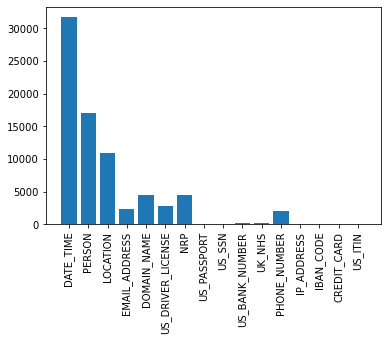

In [13]:
import matplotlib.pyplot as plt
plt.xticks(rotation=90)
plt.bar(*zip(*stats.allPIICounts().items()))
print(stats.allPIICounts().keys())
plt.show()

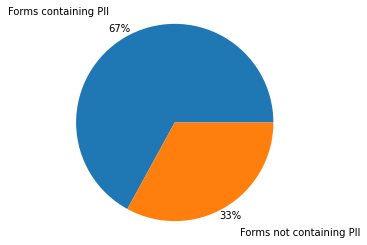

In [14]:
labels = []
sizes = []

for x, y in stats.formIncludesPII().items():
    labels.append(x)
    sizes.append(y)

# Plot
plt.pie(sizes, labels=labels, autopct='%1.0f%%', pctdistance=1.1, labeldistance=1.3, radius=1.5)

plt.axis('equal')
plt.show()

In [15]:
stats.PIIScores() # PII olarak date'i alma, driver license, phone number etc.
# önemli, IP address gibi hşeyleri dikkate al

{'DATE_TIME': {'0.85': 106742,
  '0.95': 112,
  '0.6': 261,
  '0.1': 149,
  '0.2': 27,
  '0.55': 4,
  '0.45': 16},
 'PERSON': {'0.85': 34762},
 'LOCATION': {'0.85': 23509},
 'EMAIL_ADDRESS': {'1.0': 2821},
 'DOMAIN_NAME': {'1.0': 6600},
 'US_DRIVER_LICENSE': {'0.3': 5264, '0.01': 884, '0.65': 369, '0.4': 28},
 'NRP': {'0.85': 6218},
 'US_PASSPORT': {'0.05': 21},
 'US_SSN': {'0.05': 75, '0.85': 1},
 'US_BANK_NUMBER': {'0.05': 344, '0.4': 58},
 'UK_NHS': {'1.0': 197},
 'PHONE_NUMBER': {'0.7': 2402,
  '1.0': 507,
  '0.4': 15,
  '0.05': 126,
  '0.5': 11,
  '0.85': 3},
 'IP_ADDRESS': {'0.6': 44, '0.95': 4},
 'IBAN_CODE': {'1.0': 14},
 'CREDIT_CARD': {'1.0': 3},
 'US_ITIN': {'0.3': 1}}

  0%|          | 0/16 [00:00<?, ?it/s]

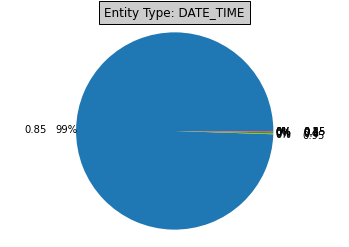

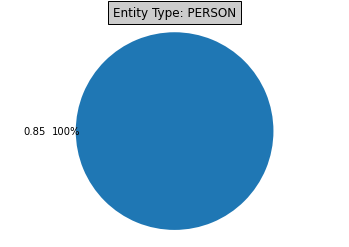

 12%|█▎        | 2/16 [00:00<00:01,  8.15it/s]

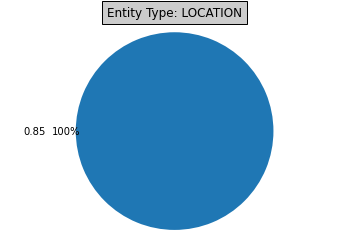

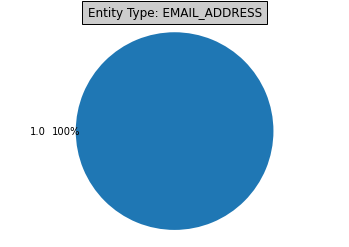

 25%|██▌       | 4/16 [00:00<00:01, 11.95it/s]

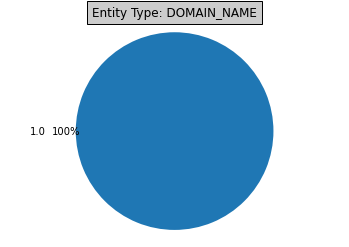

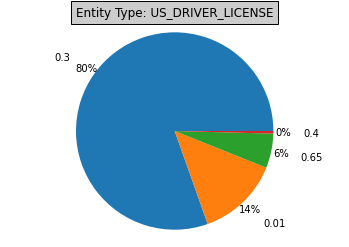

 38%|███▊      | 6/16 [00:00<00:00, 13.27it/s]

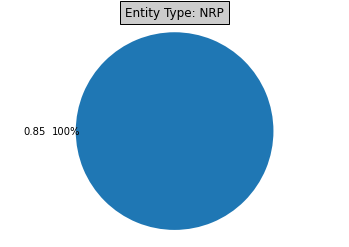

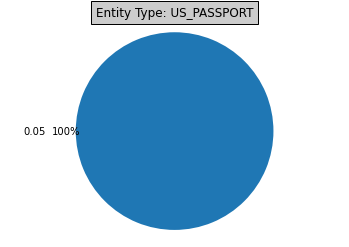

 50%|█████     | 8/16 [00:00<00:00, 14.60it/s]

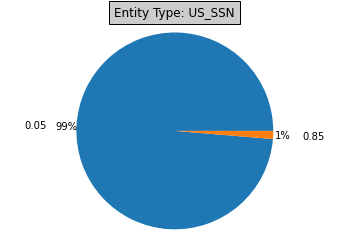

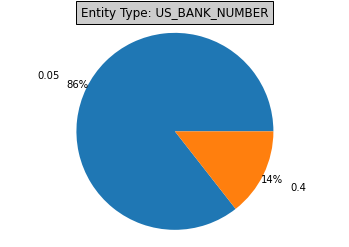

 62%|██████▎   | 10/16 [00:00<00:00, 15.01it/s]

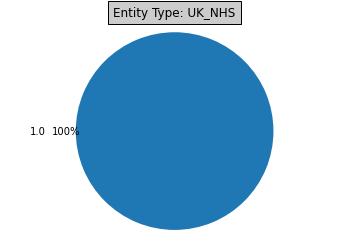

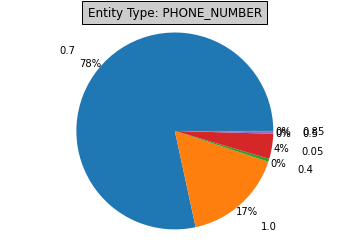

 75%|███████▌  | 12/16 [00:00<00:00, 14.28it/s]

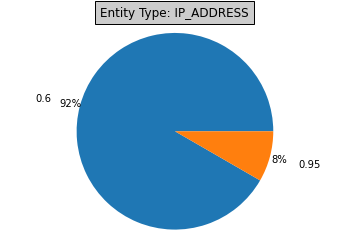

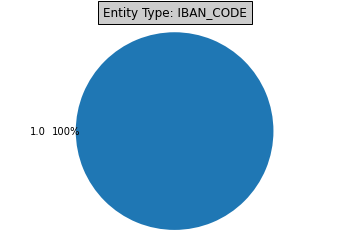

 88%|████████▊ | 14/16 [00:01<00:00, 15.14it/s]

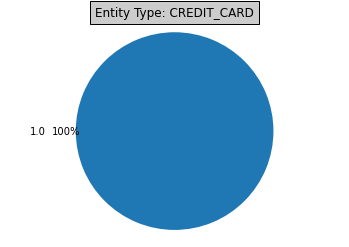

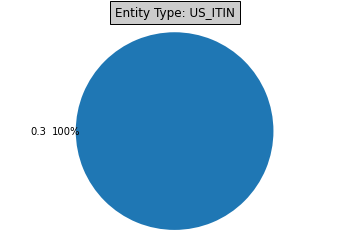

100%|██████████| 16/16 [00:01<00:00, 14.33it/s]


In [16]:
plt.xticks(rotation=90)
for entity_type, scores in tqdm(stats.PIIScores().items()):  
    labels = []
    sizes = []

    for x, y in scores.items():
        labels.append(x)
        sizes.append(y)

    plt.pie(sizes, labels=labels, autopct='%1.0f%%', pctdistance=1.1, labeldistance=1.3, radius=1)
    plt.title("Entity Type: " + entity_type, bbox={'facecolor':'0.8', 'pad':5})
    
    plt.axis('equal')
    plt.show()

